### 0. Mounting Data from Drive

In [ ]:
# prompt: load drive from google colab, force remount true

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1. Model Setup & DataLoaders

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import random
from PIL import Image
from torchvision import transforms

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file, delimiter=';', header=None,
                                      names=['filename', 'left', 'top', 'right', 'bottom', 'class'])
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        box_data = self.img_labels.iloc[idx, 1:5].values.astype(float)
        boxes = torch.tensor(box_data, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor([self.img_labels.iloc[idx, 5]], dtype=torch.int64)

        target = {'boxes': boxes, 'labels': label}

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


from torchvision.transforms import functional as F

def get_transform(train):
    def apply_transforms(image, target):
        # Convert image to tensor first if it's not one
        if not isinstance(image, torch.Tensor):
            image = F.to_tensor(image)

        # Check if training (to apply training specific transforms)
        if train:
            # Random horizontal flip with a probability of 0.5
            if torch.rand(1) < 0.5:
                image = F.hflip(image)
                # Assuming target['boxes'] is in the format [x1, y1, x2, y2]
                image_width = image.shape[-1]  # Get image width from tensor shape
                bbox = target['boxes']
                # Flip the bounding boxes accordingly
                bbox[:, [0, 2]] = image_width - bbox[:, [2, 0]]
                target['boxes'] = bbox

        return image, target

    return apply_transforms


def create_model(num_classes):
    # Load a pre-trained model for classification and return
    # only the features
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    # Anchors
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),  # One size for each feature map
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Same aspect ratios for each feature map level
    )

    # RoI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3', 'pool'],
        output_size=7,
        sampling_ratio=2
    )

    # Put it all together inside a FasterRCNN model.
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

annotations_file = '/content/drive/MyDrive/GTD/gt.txt'
img_dir = '/content/drive/MyDrive/GTD/train'

train_dataset = TrafficSignDataset(annotations_file, img_dir, get_transform(train=True))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Define the model
num_classes = 44  # example including background
model = create_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### 2. Training

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(data_loader, desc="Training Epoch"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    average_loss = running_loss / len(data_loader)
    return average_loss

# Assuming the 'model' and 'train_loader' are defined and initialized as shown in the previous snippet
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

torch.save(model.state_dict(), f'/content/drive/MyDrive/GTD/TSDetector_{epoch+1}.pth')
print('Saved Model Weight successfully')

Training Epoch: 100%|██████████| 213/213 [02:04<00:00,  1.71it/s]


Epoch 1, Loss: 0.0633


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 2, Loss: 0.0567


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 3, Loss: 0.0595


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 4, Loss: 0.0700


Training Epoch: 100%|██████████| 213/213 [02:06<00:00,  1.69it/s]


Epoch 5, Loss: 0.0567


Training Epoch: 100%|██████████| 213/213 [02:06<00:00,  1.69it/s]


Epoch 6, Loss: 0.0473


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 7, Loss: 0.0473


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 8, Loss: 0.0438


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 9, Loss: 0.0458


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 10, Loss: 0.0484


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 11, Loss: 0.0476


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 12, Loss: 0.0465


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 13, Loss: 0.0466


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 14, Loss: 0.0423


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 15, Loss: 0.0363


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 16, Loss: 0.0384


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 17, Loss: 0.0390


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 18, Loss: 0.0364


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 19, Loss: 0.0359


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 20, Loss: 0.0358


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 21, Loss: 0.0378


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 22, Loss: 0.0423


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 23, Loss: 0.0403


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 24, Loss: 0.0398


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 25, Loss: 0.0402


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 26, Loss: 0.0402


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 27, Loss: 0.0351


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 28, Loss: 0.0337


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 29, Loss: 0.0376


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 30, Loss: 0.0345


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 31, Loss: 0.0359


Training Epoch: 100%|██████████| 213/213 [02:06<00:00,  1.69it/s]


Epoch 32, Loss: 0.0369


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 33, Loss: 0.0368


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 34, Loss: 0.0382


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 35, Loss: 0.0365


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 36, Loss: 0.0347


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 37, Loss: 0.0345


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 38, Loss: 0.0324


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 39, Loss: 0.0321


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 40, Loss: 0.0329


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 41, Loss: 0.0343


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 42, Loss: 0.0380


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 43, Loss: 0.0353


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 44, Loss: 0.0334


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 45, Loss: 0.0319


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 46, Loss: 0.0303


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 47, Loss: 0.0303


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 48, Loss: 0.0293


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 49, Loss: 0.0312


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 50, Loss: 0.0324


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 51, Loss: 0.0336


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 52, Loss: 0.0334


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 53, Loss: 0.0334


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 54, Loss: 0.0293


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 55, Loss: 0.0291


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 56, Loss: 0.0287


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 57, Loss: 0.0296


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 58, Loss: 0.0286


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 59, Loss: 0.0274


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 60, Loss: 0.0278


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 61, Loss: 0.0274


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 62, Loss: 0.0289


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 63, Loss: 0.0279


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 64, Loss: 0.0286


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 65, Loss: 0.0273


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 66, Loss: 0.0266


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 67, Loss: 0.0257


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 68, Loss: 0.0261


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 69, Loss: 0.0261


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 70, Loss: 0.0282


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 71, Loss: 0.0252


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 72, Loss: 0.0245


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 73, Loss: 0.0286


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.69it/s]


Epoch 74, Loss: 0.0273


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 75, Loss: 0.0241


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 76, Loss: 0.0232


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 77, Loss: 0.0251


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 78, Loss: 0.0225


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 79, Loss: 0.0219


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 80, Loss: 0.0217


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 81, Loss: 0.0224


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 82, Loss: 0.0235


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 83, Loss: 0.0247


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 84, Loss: 0.0235


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 85, Loss: 0.0229


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 86, Loss: 0.0250


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 87, Loss: 0.0255


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 88, Loss: 0.0239


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 89, Loss: 0.0245


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 90, Loss: 0.0249


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 91, Loss: 0.0228


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 92, Loss: 0.0224


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 93, Loss: 0.0243


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 94, Loss: 0.0254


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 95, Loss: 0.0270


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 96, Loss: 0.0280


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 97, Loss: 0.0285


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 98, Loss: 0.0247


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 99, Loss: 0.0270


Training Epoch: 100%|██████████| 213/213 [02:05<00:00,  1.70it/s]


Epoch 100, Loss: 0.0268
Saved Model Weight successfully


### 3. Testing

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
from tqdm import tqdm
import pandas as pd

# Assuming the dataset class and transform function have already been defined

# Load the test dataset
test_dataset = TrafficSignDataset(
    annotations_file='/content/drive/MyDrive/GTD/gt.txt',
    img_dir='/content/drive/MyDrive/GTD/train',
    transforms=get_transform(train=False)  # Apply the same transform as during training without augmentation
)

# DataLoader for testing
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# Load the trained model
model = create_model(num_classes)  # Ensure num_classes is defined or retrieved as shown earlier
model.load_state_dict(torch.load('/content/drive/MyDrive/GTD/TSDetector_100.pth'))  # Load your saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def evaluate(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou, total_tp, total_fn, count = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                if 'boxes' not in targets[i]:
                    continue

                target_boxes = targets[i]['boxes']
                if output['boxes'].nelement() == 0 or target_boxes.nelement() == 0:
                    continue

                iou = box_iou(output['boxes'], target_boxes)
                max_iou, _ = iou.max(dim=1)
                total_tp += (max_iou > iou_threshold).sum().item()
                total_fn += (max_iou <= iou_threshold).sum().item()
                total_iou += iou.diag().sum().item()
                count += output['boxes'].size(0)

        avg_iou = total_iou / count if count > 0 else 0
        precision = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
        recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        print(f"\nAverage IoU: {avg_iou:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1_score:.2f}")

# Evaluate the model
evaluate(model, test_loader, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|██████████| 213/213 [09:08<00:00,  2.57s/it]


Average IoU: 0.26
Precision: 0.47
Recall: 0.47
F1 Score: 0.47


### 4. Prediction of Object Detection & Visualization

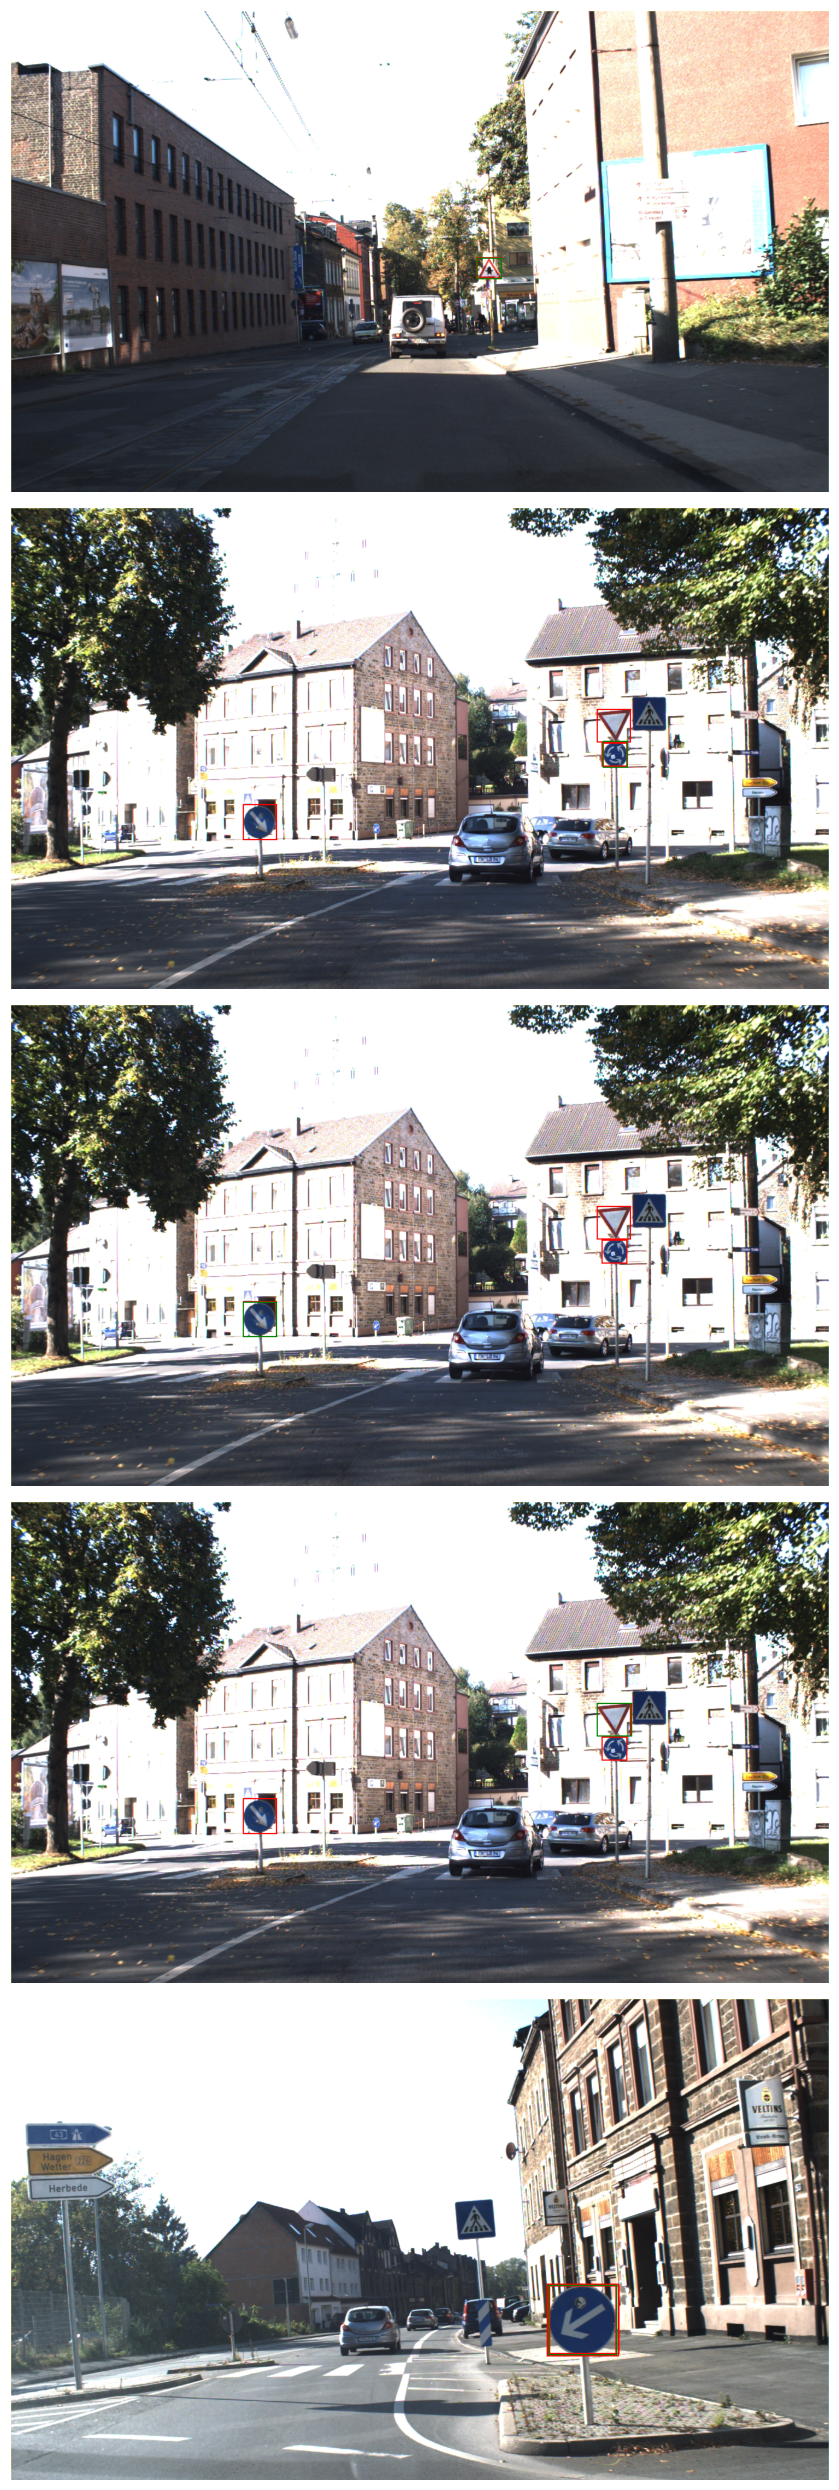

In [ ]:
import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from copy import deepcopy

def visualize_predictions(model, dataset, device, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_images, 1, figsize=(10, 5 * num_images))  # Adjusted to column-wise layout
    with torch.no_grad():
        for idx, (image, target) in enumerate(dataset):
            if idx == num_images:
                break

            # Move image to device
            image = image.to(device)
            output = model([image])[0]

            # Convert image back to CPU
            image = image.cpu()
            output_boxes = output['boxes'].cpu()
            target_boxes = target['boxes'].cpu()

            # Convert image to PIL and copy it to avoid altering original
            image_pil = deepcopy(F.to_pil_image(image))
            draw = ImageDraw.Draw(image_pil)

            # Draw the predicted boxes
            for box in output_boxes:
                draw.rectangle(box.tolist(), outline='red', width=2)

            # Draw the ground truth boxes
            for box in target_boxes:
                draw.rectangle(box.tolist(), outline='green', width=2)

            ax = axes[idx]
            ax.imshow(image_pil)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_images=5)


### 5. Testing the Best Classification Model

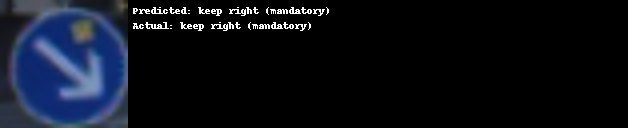

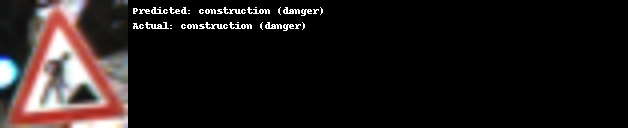

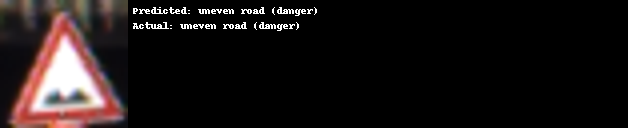

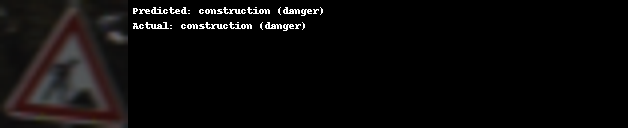

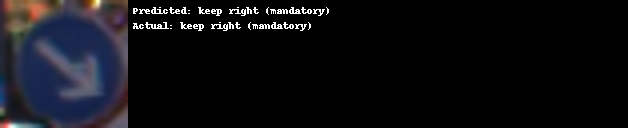

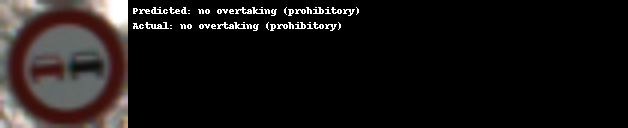

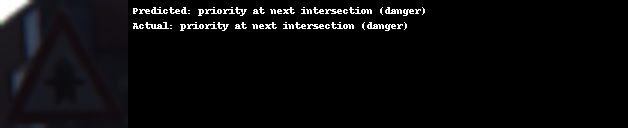

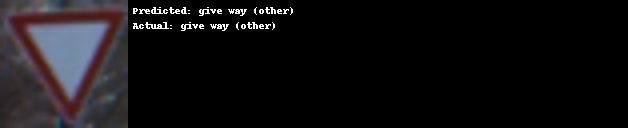

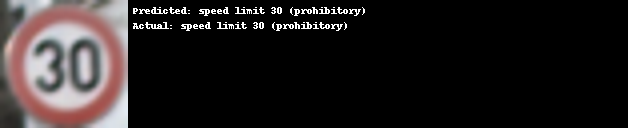

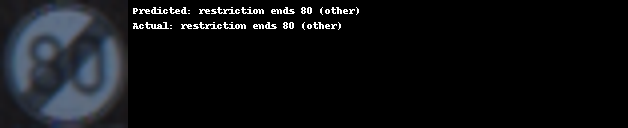

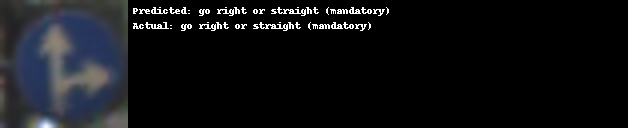

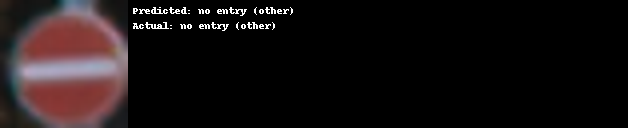

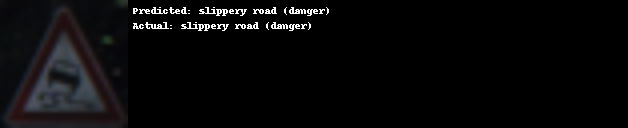

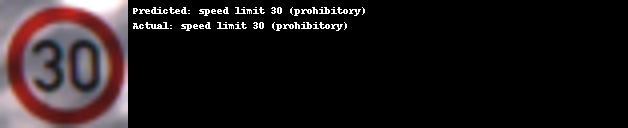

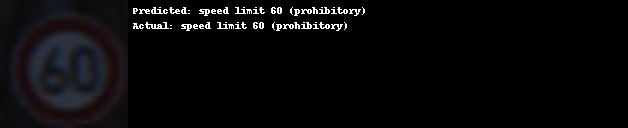

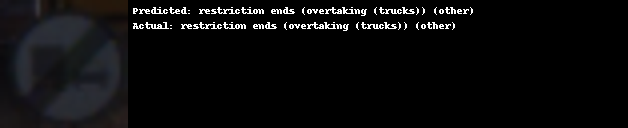

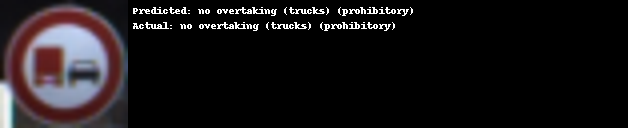

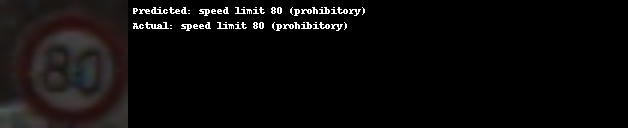

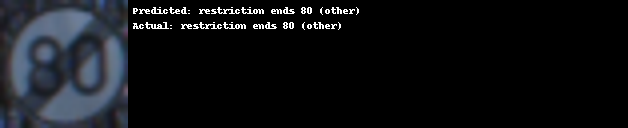

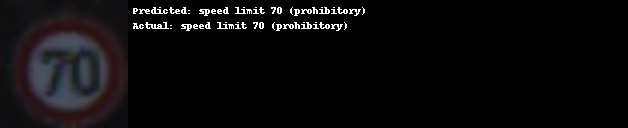

In [ ]:
# Import statements
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from IPython.display import display
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import os

# Set base directory
base_dir = '/content/drive/MyDrive/'
root_directory = base_dir + 'traffic_symbol_classification'

# Custom dataset class definition
class GermanTrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels
        for label_dir in os.listdir(self.root_dir):
            if label_dir == '.DS_Store':  # Skip .DS_Store files
                continue
            try:
                class_id = int(label_dir)  # Convert folder name to integer label
            except ValueError:
                continue
            class_dir = os.path.join(self.root_dir, label_dir)
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(class_id)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to be consistent with model input
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Instantiate the dataset
dataset = GermanTrafficSignDataset(root_dir=root_directory, transform=transform)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Prediction and display function
def predict_and_display_individual_test_images_pil_colab(model, weight_key, num_images=5, image_size=128, text_width=500):
    # Load your trained model
    model.load_state_dict(torch.load(base_dir + weight_key + '.pth'))
    model.eval()  # Set the model to evaluation mode

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    class_names = {
        0: 'speed limit 20 (prohibitory)',
        1: 'speed limit 30 (prohibitory)',
        2: 'speed limit 50 (prohibitory)',
        3: 'speed limit 60 (prohibitory)',
        4: 'speed limit 70 (prohibitory)',
        5: 'speed limit 80 (prohibitory)',
        6: 'restriction ends 80 (other)',
        7: 'speed limit 100 (prohibitory)',
        8: 'speed limit 120 (prohibitory)',
        9: 'no overtaking (prohibitory)',
        10: 'no overtaking (trucks) (prohibitory)',
        11: 'priority at next intersection (danger)',
        12: 'priority road (other)',
        13: 'give way (other)',
        14: 'stop (other)',
        15: 'no traffic both ways (prohibitory)',
        16: 'no trucks (prohibitory)',
        17: 'no entry (other)',
        18: 'danger (danger)',
        19: 'bend left (danger)',
        20: 'bend right (danger)',
        21: 'bend (danger)',
        22: 'uneven road (danger)',
        23: 'slippery road (danger)',
        24: 'road narrows (danger)',
        25: 'construction (danger)',
        26: 'traffic signal (danger)',
        27: 'pedestrian crossing (danger)',
        28: 'school crossing (danger)',
        29: 'cycles crossing (danger)',
        30: 'snow (danger)',
        31: 'animals (danger)',
        32: 'restriction ends (other)',
        33: 'go right (mandatory)',
        34: 'go left (mandatory)',
        35: 'go straight (mandatory)',
        36: 'go right or straight (mandatory)',
        37: 'go left or straight (mandatory)',
        38: 'keep right (mandatory)',
        39: 'keep left (mandatory)',
        40: 'roundabout (mandatory)',
        41: 'restriction ends (overtaking) (other)',
        42: 'restriction ends (overtaking (trucks)) (other)'
    }

    # Randomly select a subset of test images
    indices = np.random.choice(range(len(test_dataset)), num_images, replace=False)
    subset = Subset(test_dataset, indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

    # Load and predict each image
    for images, labels in subset_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        label = predicted.item()

        # Convert the image back to PIL format
        image_np = (images[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
        image_np = image_np.astype(np.uint8)
        image_pil = Image.fromarray(image_np).resize((image_size, image_size))

        # Create a new image with extra space for the text to the right
        result_image = Image.new('RGB', (image_size + text_width, image_size), (0, 0, 0))
        result_image.paste(image_pil, (0, 0))

        # Draw text to the right of the image
        draw = ImageDraw.Draw(result_image)
        predicted_label = class_names[label]
        actual_label = class_names[labels.item()]
        text = f'Predicted: {predicted_label}\nActual: {actual_label}'
        draw.text((image_size + 5, 5), text, fill='white')

        # Display each image individually using Colab's display function
        display(result_image)


# Usage example
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
predict_and_display_individual_test_images_pil_colab(model, weight_key='resnet50', num_images=20, image_size=128, text_width=500)


### 6. Integrating TS-Detector (Our Custom Object Detection Model) with the Best Classification Model

Loaded classification model successfully.
Using device: cuda:0
Loading object detection model weights...
Creating object detection model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Backbone loaded successfully.
Loaded object detection model successfully.
Loading test dataset...
Loaded test dataset successfully.
FONT LOADED
Loading image: /content/drive/MyDrive/GTD/train/00000.ppm
Processing image 1/5
Running object detection...
Detected 1 boxes
Cropped object with bounding box: [773.7071533203125, 410.9665832519531, 815.1226806640625, 445.64471435546875]
Classifying traffic sign...
Predicted label: 11
Loading image: /content/drive/MyDrive/GTD/train/00001.ppm
Processing image 2/5
Running object detection...
Detected 3 boxes
Cropped object with bounding box: [386.6057434082031, 493.5772399902344, 442.3082275390625, 552.1930541992188]
Classifying traffic sign...
Predicted label: 38
Cropped object with bounding box: [973.541015625, 335.8859558105469, 1029.6788330078125, 390.1387939453125]
Classifying traffic sign...
Predicted label: 13
Cropped object with bounding box: [981.34375, 391.32232666015625, 1023.7250366210938, 430.302490234375]
Classifying traffic sign...
P

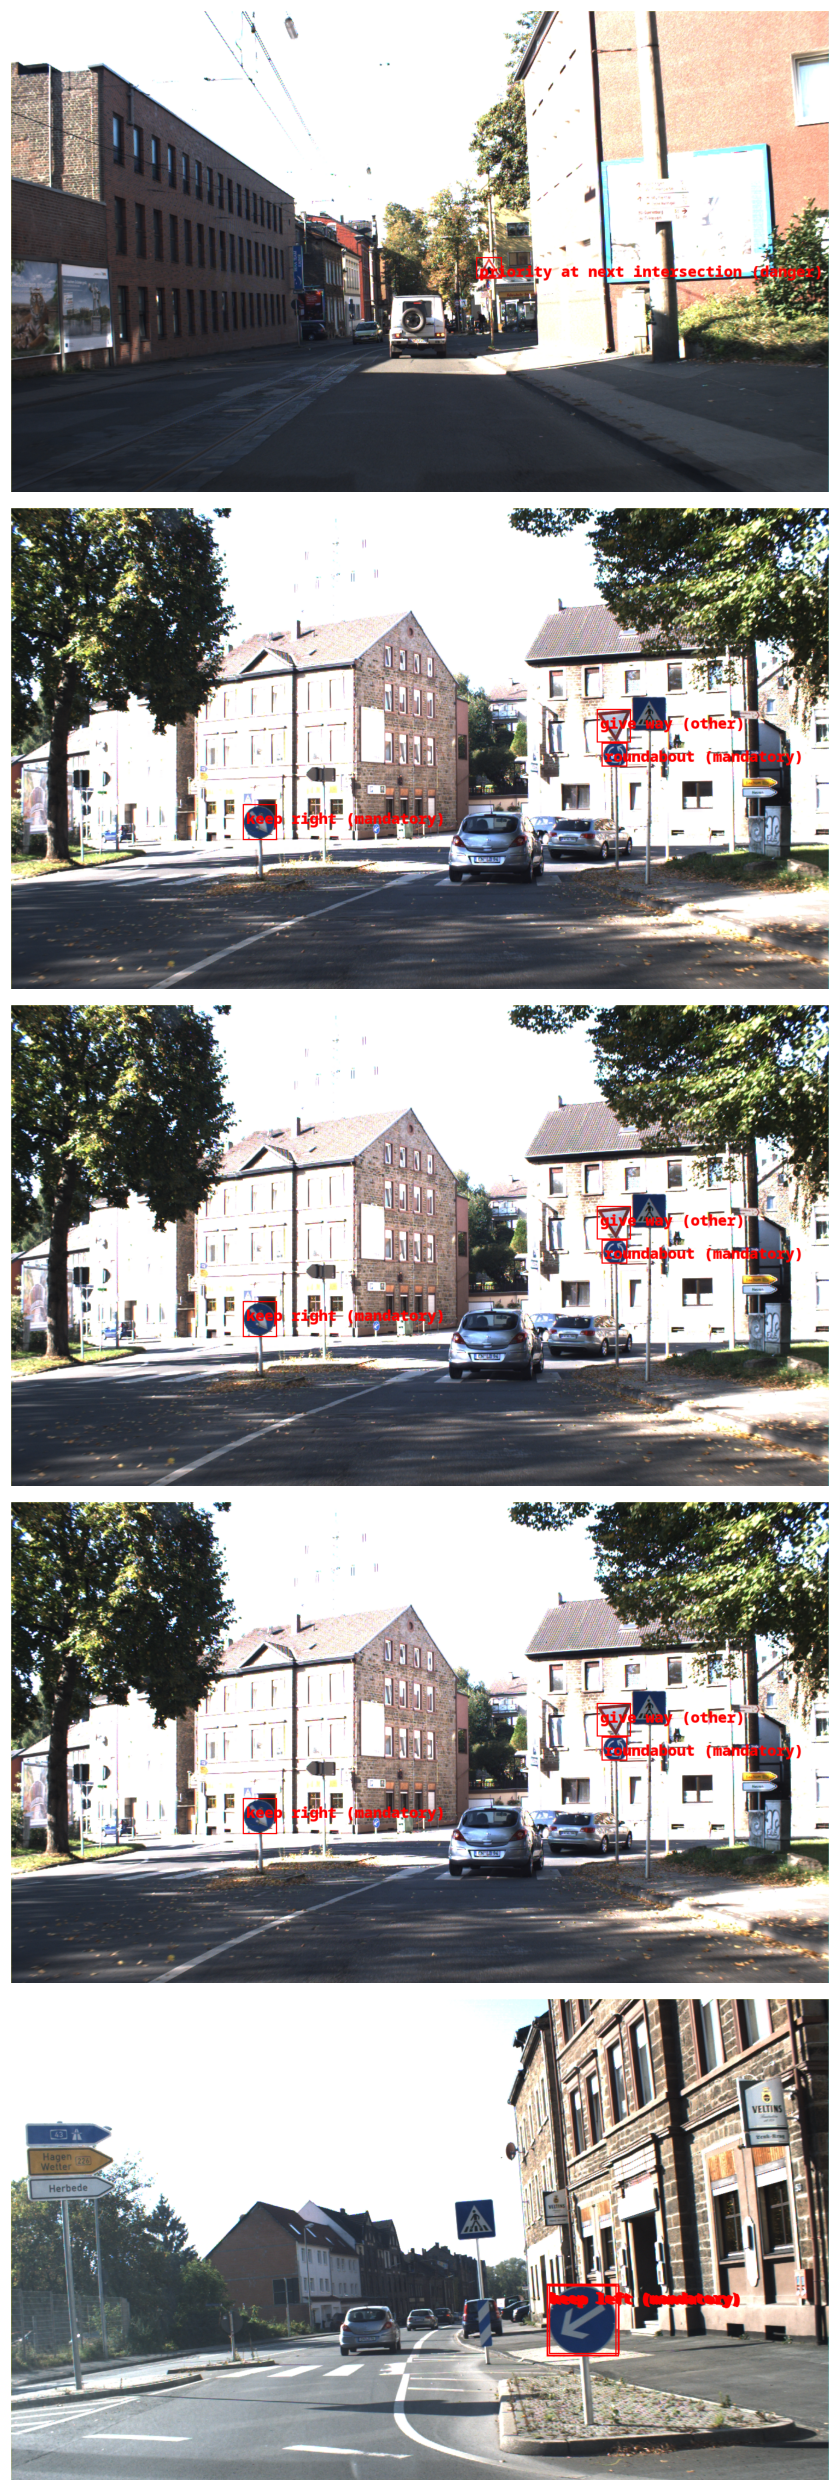

In [36]:
import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from copy import deepcopy
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import pandas as pd
import os

# Base directory for loading models
base_dir = '/content/drive/MyDrive/'

# Load your pre-trained classification model (ResNet50)
class_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = class_model.fc.in_features
class_model.fc = nn.Linear(num_ftrs, 43)  # Assuming 43 classes
class_model.load_state_dict(torch.load(base_dir + 'resnet50.pth'))
class_model.eval()  # Set the model to evaluation mode
print("Loaded classification model successfully.")

# Move classification model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class_model = class_model.to(device)

# Load your object detection model
def create_model(num_classes):
    print("Creating object detection model...")
    # Load a pre-trained model for classification and return only the features
    backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.DEFAULT)
    print("Backbone loaded successfully.")

    # Anchors
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),  # One size for each feature map
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Same aspect ratios for each feature map level
    )

    # RoI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3', 'pool'],
        output_size=7,
        sampling_ratio=2
    )

    # Put it all together inside a FasterRCNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Load the trained object detection model
num_classes = 44  # including background
print("Loading object detection model weights...")
detection_model = create_model(num_classes)
detection_model.load_state_dict(torch.load('/content/drive/MyDrive/GTD/TSDetector_100.pth'))
detection_model.eval()
detection_model = detection_model.to(device)
print("Loaded object detection model successfully.")

# Define the transformation for classification
classification_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Class names mapping for classification
class_names = {
    0: 'speed limit 20 (prohibitory)',
    1: 'speed limit 30 (prohibitory)',
    2: 'speed limit 50 (prohibitory)',
    3: 'speed limit 60 (prohibitory)',
    4: 'speed limit 70 (prohibitory)',
    5: 'speed limit 80 (prohibitory)',
    6: 'restriction ends 80 (other)',
    7: 'speed limit 100 (prohibitory)',
    8: 'speed limit 120 (prohibitory)',
    9: 'no overtaking (prohibitory)',
    10: 'no overtaking (trucks) (prohibitory)',
    11: 'priority at next intersection (danger)',
    12: 'priority road (other)',
    13: 'give way (other)',
    14: 'stop (other)',
    15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)',
    17: 'no entry (other)',
    18: 'danger (danger)',
    19: 'bend left (danger)',
    20: 'bend right (danger)',
    21: 'bend (danger)',
    22: 'uneven road (danger)',
    23: 'slippery road (danger)',
    24: 'road narrows (danger)',
    25: 'construction (danger)',
    26: 'traffic signal (danger)',
    27: 'pedestrian crossing (danger)',
    28: 'school crossing (danger)',
    29: 'cycles crossing (danger)',
    30: 'snow (danger)',
    31: 'animals (danger)',
    32: 'restriction ends (other)',
    33: 'go right (mandatory)',
    34: 'go left (mandatory)',
    35: 'go straight (mandatory)',
    36: 'go right or straight (mandatory)',
    37: 'go left or straight (mandatory)',
    38: 'keep right (mandatory)',
    39: 'keep left (mandatory)',
    40: 'roundabout (mandatory)',
    41: 'restriction ends (overtaking) (other)',
    42: 'restriction ends (overtaking (trucks)) (other)'
}

def classify_traffic_sign(image_crop):
    """Classify a traffic sign given a cropped image."""
    print("Classifying traffic sign...")
    image_tensor = classification_transform(image_crop).unsqueeze(0).to(device)
    output = class_model(image_tensor)
    _, predicted_label = torch.max(output, 1)
    print(f"Predicted label: {predicted_label.item()}")
    return class_names[predicted_label.item()]

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file, delimiter=';', header=None,
                                      names=['filename', 'left', 'top', 'right', 'bottom', 'class'])
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        print(f"Loading image: {img_path}")

        box_data = self.img_labels.iloc[idx, 1:5].values.astype(float)
        boxes = torch.tensor(box_data, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor([self.img_labels.iloc[idx, 5]], dtype=torch.int64)

        target = {'boxes': boxes, 'labels': label}

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

def visualize_predictions_with_classification(detection_model, dataset, device, num_images=5):
    detection_model.eval()
    fig, axes = plt.subplots(num_images, 1, figsize=(10, 5 * num_images))
    # try:
    #     font = ImageFont.truetype("DejaVuSans.ttf", size=100)  # Adjust font size as needed
    # except IOError:
    #     print("Failed to load font file. Using default font.")
    #     font = ImageFont.load_default()
    # print("Starting visualization...")
    try:
      font = ImageFont.truetype("/content/NotoSansMono-Black.ttf", size=25)  # Adjust font size as needed
      print("FONT LOADED")
      print(font)
    except IOError:
      print("Failed to load font file. Using default font.")
      font = ImageFont.load_default()
      print("Starting visualization...")

    with torch.no_grad():
        for idx, (image, target) in enumerate(dataset):
            if idx == num_images:
                break
            print(f"Processing image {idx + 1}/{num_images}")

            # Convert image to tensor and move to device
            image_tensor = F.to_tensor(image).to(device).unsqueeze(0)
            print("Running object detection...")
            output = detection_model(image_tensor)[0]

            # Convert image back to CPU as a PIL image
            image_pil = deepcopy(F.to_pil_image(image_tensor[0].cpu()))
            output_boxes = output['boxes'].cpu()
            print(f"Detected {len(output_boxes)} boxes")

            draw = ImageDraw.Draw(image_pil)

            # Draw the predicted boxes and classify the objects inside
            for box in output_boxes:
                box = box.tolist()
                draw.rectangle(box, outline='red', width=2)

                # Crop the detected object
                object_crop = image_pil.crop(box)
                print(f"Cropped object with bounding box: {box}")

                # Classify the cropped object
                predicted_label = classify_traffic_sign(object_crop)

                # Draw the classification label with a dark color
                draw.text((box[0] + 5, box[1] + 5), predicted_label, fill='red', font=font)

            ax = axes[idx]
            ax.imshow(image_pil)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load test dataset
annotations_file = '/content/drive/MyDrive/GTD/gt.txt'
img_dir = '/content/drive/MyDrive/GTD/train'
print("Loading test dataset...")
test_dataset = TrafficSignDataset(annotations_file, img_dir)
print("Loaded test dataset successfully.")

# Visualize predictions with classification labels
visualize_predictions_with_classification(detection_model, test_dataset, device, num_images=5)


#### Extras (Utility function to Download Font for Traffic Symbol Labelling)

In [32]:
import requests
from PIL import ImageFont

# URL of the font file you want to download
font_url = "https://github.com/notofonts/notofonts.github.io/blob/main/fonts/NotoSansMono/googlefonts/ttf/NotoSansMono-Black.ttf?raw=true"

# Send a GET request to download the font file
response = requests.get(font_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the font file
    with open("/content/NotoSansMono-Black.ttf", "wb") as f:
        f.write(response.content)
    print("Font file downloaded successfully.")
else:
    print("Failed to download font file.")

# Use the downloaded font file
font_path = "/content/NotoSansMono-Black.ttf"  # Path to the downloaded font file
font_size = 100  # Adjust the font size as needed
font = ImageFont.truetype(font_path, size=font_size)

# Now you can use the 'font' object for visualization as needed


Font file downloaded successfully.
